In [34]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling1D, ZeroPadding1D, Flatten, Reshape, Conv1D, BatchNormalization, Activation
from keras import regularizers
from sklearn.model_selection import train_test_split

import torch
from torch.utils import data

from magnet.src.data_reader.dataset import TotalMagnetDataset
from magnet.src.model.model import CDCK2

In [35]:
q001_data_raw = np.load('/data1/ryan/train-files/train_q001_bot.npy')
q003_data_raw = np.load('/data1/ryan/train-files/train_q003_bot.npy')
q076_data_raw = np.load('/data1/ryan/train-files/train_q076_bot.npy')
q103_data_raw = np.load('/data1/ryan/train-files/train_q103_bot.npy')

#don't normalize over the whole quench, normalize each image
q001_data = np.zeros_like(q001_data_raw)
q003_data = np.zeros_like(q003_data_raw)
q076_data = np.zeros_like(q076_data_raw)
q103_data = np.zeros_like(q103_data_raw)

#it's not pretty but it works
for i, im in enumerate(q001_data_raw):
    q001_data[i,:] = q001_data_raw[i,:] / np.max(q001_data_raw[i,:])

for i, im in enumerate(q003_data_raw):
    q003_data[i,:] = q003_data_raw[i,:] / np.max(q003_data_raw[i,:])
    
for i, im in enumerate(q076_data_raw):
    q076_data[i,:] = q076_data_raw[i,:] / np.max(q076_data_raw[i,:])
    
for i, im in enumerate(q103_data_raw):
    q103_data[i,:] = q103_data_raw[i,:] / np.max(q103_data_raw[i,:])

In [36]:
#we shuffle in the training so it's ok
#i guess we lose some in the shuffle?
#shuffle by default
qall_data = np.concatenate((q001_data, q003_data, q076_data, q103_data), axis=0)
print(qall_data.shape)
data_mod = np.empty((qall_data.shape[0], qall_data.shape[1], 1))
data_mod[:, :, 0] = qall_data

x_train_temp, x_test_temp = train_test_split(qall_data, random_state=42)
print(x_train_temp.shape)
print(x_test_temp.shape)

x_train = np.empty((x_train_temp.shape[0], x_train_temp.shape[1], 1))
x_test = np.empty((x_test_temp.shape[0], x_test_temp.shape[1], 1))
x_train[:, :, 0] = x_train_temp
x_test[:, :, 0] = x_test_temp

print(x_train.shape)
print(x_test.shape)

(22820, 2000)
(17115, 2000)
(5705, 2000)
(17115, 2000, 1)
(5705, 2000, 1)


In [37]:
# Is the network really learning anything??? Raw Data with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
#need to flatten i guess?
img_pca = pca.fit_transform(qall_data)

#boundary 1
boundary1 = q001_data.shape[0]
#boundary 2
boundary2 = boundary1 + q003_data.shape[0]
#boundary 3
boundary3 = boundary2 + q076_data.shape[0]

color_key=['red','orange','green','blue']
color_label=[]
for i in range(qall_data.shape[0]):
    if i <= boundary1:
        color_label.append(color_key[0])
    elif boundary1 <= i < boundary2:
        color_label.append(color_key[1])
    elif boundary2 <= i < boundary3: 
        color_label.append(color_key[2])
    else:
        color_label.append(color_key[3])
        
print(len(color_label))

22820


In [38]:
print('The first component:', pca.explained_variance_ratio_[0])
print('The second component:', pca.explained_variance_ratio_[1])
print('They don\'t take much of the variance...')

The first component: 0.027102371453172215
The second component: 0.025613046468319897
They don't take much of the variance...


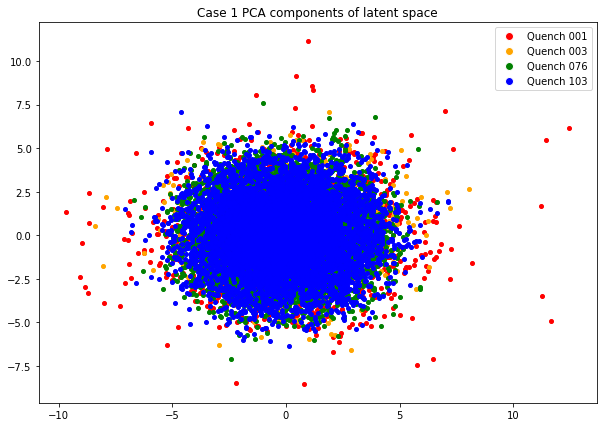

In [7]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

msize = 16

# hack the legend together
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Quench 001',
                          markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 003',
                          markerfacecolor='orange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 076',
                          markerfacecolor='green', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 103',
                          markerfacecolor='blue', markersize=8)]

# Create the figure and add our hacked legend
plt.figure(figsize=(10, 7))
for i in range(qall_data.shape[0]):
    plt.scatter(img_pca[i,0],img_pca[i,1], s=msize, color=color_label[i])
plt.title('Case 1 PCA components of latent space')
plt.legend(handles=legend_elements)
plt.show()

In [39]:
# How does Maxim's hypothesis fit with the results?
batch = 64
timestep = 12
audio_window = 2000

model = CDCK2(timestep, batch, audio_window).to('cuda')
model.load_state_dict(torch.load('/data1/ryan/snapshot/cdc/cdc-2019-11-04_12_32_57-model_best.pth')['state_dict'])
model.eval()

CDCK2(
  (encoder): Sequential(
    (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), padding=(3,), bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(512, 512, kernel_size=(8,), stride=(5,), padding=(2,), bias=False)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_

In [40]:
total_set = TotalMagnetDataset('', '', audio_window)
params = {'num_workers': 0,
          'pin_memory': False}
final_loader = data.DataLoader(total_set, batch_size=batch, shuffle=False, **params)

In [41]:
encoded_all = []

for batch_idx, ex in enumerate(final_loader):
    ex = ex.float().unsqueeze(1).to('cuda')  # add channel dimension
    hidden = model.init_hidden(len(ex), use_gpu=True)
    result = model.encoder(ex)
    encoded_all += result.tolist()

encoded_all = np.array(encoded_all)
print(encoded_all.shape)

(22820, 512, 40)


In [42]:
encoded = encoded_all[:, 128, :]
print(encoded.shape)

(22820, 40)


In [43]:
# Finally, try using DBSCAN to directly cluster high-dimensional data!
from sklearn.cluster import DBSCAN
# print(encoded.shape)

clustering = DBSCAN(eps=0.1).fit(encoded)
print(clustering.labels_)

[0 0 0 ... 0 0 0]


In [ ]:
from hdbscan import HDBSCAN

encoded = encoded_all[:, 128, :]
clustering = HDBSCAN().fit(encoded)
print(clustering.labels_)

In [45]:
number_of_minus = 0
number_of_zeros = 0
number_of_thirtyones = 0

for i in range(len(qall_data)):
    if clustering.labels_[i] == -1:
        number_of_minus += 1
    elif clustering.labels_[i] == 0:
        number_of_zeros += 1
    elif clustering.labels_[i] == 31:
        number_of_thirtyones += 1

print(number_of_minus + number_of_zeros + number_of_thirtyones)
print(number_of_minus)
print(number_of_zeros)
print(number_of_thirtyones)
# print(clustering.labels_.tolist())

22812
4597
18215
0


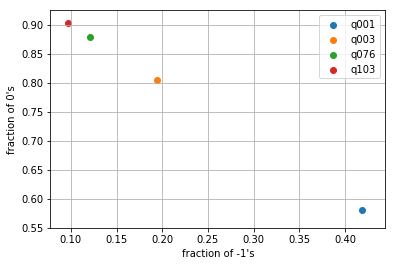

In [46]:
# All of the data
q001_minus = 0
q001_31 = 0
q003_minus = 0
q003_31 = 0
q076_minus = 0
q076_31 = 0
q103_minus = 0
q103_31 = 0

for i in range(len(encoded)):
    if i < boundary1:
        if clustering.labels_[i] == -1:
            q001_minus += 1
        elif clustering.labels_[i] == 0:
            q001_31 += 1
    elif i < boundary2:
        if clustering.labels_[i] == -1:
            q003_minus += 1
        elif clustering.labels_[i] == 0:
            q003_31 += 1
    elif i < boundary3:
        if clustering.labels_[i] == -1:
            q076_minus += 1
        elif clustering.labels_[i] == 0:
            q076_31 += 1
    else:
        if clustering.labels_[i] == -1:
            q103_minus += 1
        elif clustering.labels_[i] == 0:
            q103_31 += 1

plt.figure()
plt.scatter([q001_minus / q001_data.shape[0]], [q001_31 / q001_data.shape[0]])
plt.scatter([q003_minus / q003_data.shape[0]], [q003_31 / q003_data.shape[0]])
plt.scatter([q076_minus / q076_data.shape[0]], [q076_31 / q076_data.shape[0]])
plt.scatter([q103_minus / q103_data.shape[0]], [q103_31 / q103_data.shape[0]])
plt.legend(['q001', 'q003', 'q076', 'q103'])
plt.xlabel('fraction of -1\'s')
plt.ylabel('fraction of 0\'s')
plt.grid()
plt.show()

1698
1159
3900
3283


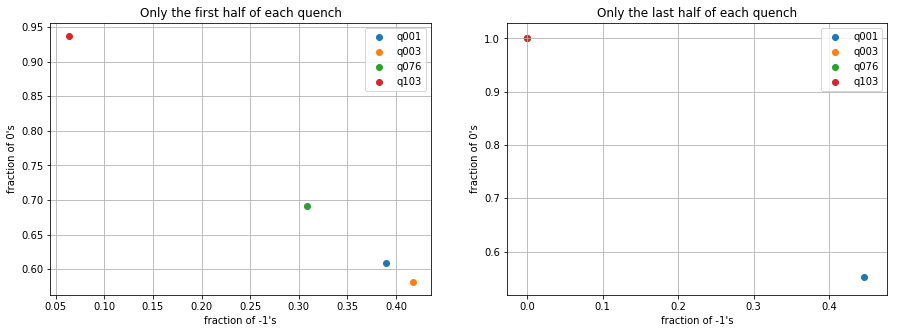

In [47]:
# Check if this coincides with Maxim's hypothesis
q001_minus = 0
q001_31 = 0
q003_minus = 0
q003_31 = 0
q076_minus = 0
q076_31 = 0
q103_minus = 0
q103_31 = 0

encoded_q001 = encoded[:int(boundary1 / 2)]
encoded_q003 = encoded[boundary1:int((boundary2-boundary1) / 2)+boundary1]
encoded_q076 = encoded[boundary2:int((boundary3-boundary2) / 2)+boundary2]
encoded_q103 = encoded[boundary3:int((len(encoded)-boundary3) / 2)+boundary3]

encoded_trun1 = np.concatenate((encoded_q001, encoded_q003), axis=0)
encoded_trun2 = np.concatenate((encoded_trun1, encoded_q076), axis=0)
encoded_trun3 = np.concatenate((encoded_trun2, encoded_q103), axis=0)

for i in range(len(encoded_trun3)):
    if i < len(encoded_q001):
        if clustering.labels_[i] == -1:
            q001_minus += 1
        elif clustering.labels_[i] == 0:
            q001_31 += 1
    elif i < len(encoded_trun1):
        if clustering.labels_[i] == -1:
            q003_minus += 1
        elif clustering.labels_[i] == 0:
            q003_31 += 1
    elif i < len(encoded_trun2):
        if clustering.labels_[i] == -1:
            q076_minus += 1
        elif clustering.labels_[i] == 0:
            q076_31 += 1
    else:
        if clustering.labels_[i] == -1:
            q103_minus += 1
        elif clustering.labels_[i] == 0:
            q103_31 += 1

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.scatter([q001_minus / encoded_q001.shape[0]], [q001_31 / encoded_q001.shape[0]])
ax1.scatter([q003_minus / encoded_q003.shape[0]], [q003_31 / encoded_q003.shape[0]])
ax1.scatter([q076_minus / encoded_q076.shape[0]], [q076_31 / encoded_q076.shape[0]])
ax1.scatter([q103_minus / encoded_q103.shape[0]], [q103_31 / encoded_q103.shape[0]])
ax1.legend(['q001', 'q003', 'q076', 'q103'])
ax1.set_title('Only the first half of each quench')
ax1.set_xlabel('fraction of -1\'s')
ax1.set_ylabel('fraction of 0\'s')
plt.grid()


# For the last half of each quench
q001_minus = 0
q001_31 = 0
q003_minus = 0
q003_31 = 0
q076_minus = 0
q076_31 = 0
q103_minus = 0
q103_31 = 0

encoded_q001 = encoded[int(boundary1 / 2):boundary1]
encoded_q003 = encoded[int((boundary2-boundary1) / 2)+boundary1:boundary2]
encoded_q076 = encoded[int((boundary3-boundary2) / 2)+boundary2:boundary3]
encoded_q103 = encoded[int((len(encoded)-boundary3) / 2)+boundary3:]

encoded_trun1 = np.concatenate((encoded_q001, encoded_q003), axis=0)
encoded_trun2 = np.concatenate((encoded_trun1, encoded_q076), axis=0)
encoded_trun3 = np.concatenate((encoded_trun2, encoded_q103), axis=0)

for i in range(len(encoded_trun3)):
    if i < len(encoded_q001):
        index = i + int(boundary1 / 2)
        if clustering.labels_[index] == -1:
            q001_minus += 1
        elif clustering.labels_[index] == 0:
            q001_31 += 1
    elif i < len(encoded_trun1):
        index = int((boundary2-boundary1) / 2)+boundary1 - len(encoded_q001)
        if clustering.labels_[index] == -1:
            q003_minus += 1
        elif clustering.labels_[index] == 0:
            q003_31 += 1
    elif i < len(encoded_trun2):
        index = int((boundary3-boundary2) / 2)+boundary2 - len(encoded_trun1)
        if clustering.labels_[index] == -1:
            q076_minus += 1
        elif clustering.labels_[index] == 0:
            q076_31 += 1
    else:
        index = int((len(encoded)-boundary3) / 2)+boundary3 - len(encoded_trun2)
        if clustering.labels_[index] == -1:
            q103_minus += 1
        elif clustering.labels_[index] == 0:
            q103_31 += 1

print(q001_31)
print(q003_31)
print(q076_31)
print(q103_31)
            
ax2 = plt.subplot(1, 2, 2)
ax2.scatter([q001_minus / encoded_q001.shape[0]], [q001_31 / encoded_q001.shape[0]])
ax2.scatter([q003_minus / encoded_q003.shape[0]], [q003_31 / encoded_q003.shape[0]])
ax2.scatter([q076_minus / encoded_q076.shape[0]], [q076_31 / encoded_q076.shape[0]])
ax2.scatter([q103_minus / encoded_q103.shape[0]], [q103_31 / encoded_q103.shape[0]])
ax2.legend(['q001', 'q003', 'q076', 'q103'])
ax2.set_title('Only the last half of each quench')
ax2.set_xlabel('fraction of -1\'s')
ax2.set_ylabel('fraction of 0\'s')
plt.grid()
plt.show()

In [ ]:
# Show this result in a different way
plt.figure()

ax1 = plt.subplot(2, 2, 1)
encoded_q001 = 

ax2 = plt.subplot(2, 2, 2)

ax3 = plt.subplot(2, 2, 3)

ax4 = plt.subplot(2, 2, 4)

plt.grid()
plt.show()

(5705, 2000, 1)
[9868, 21766, 420]


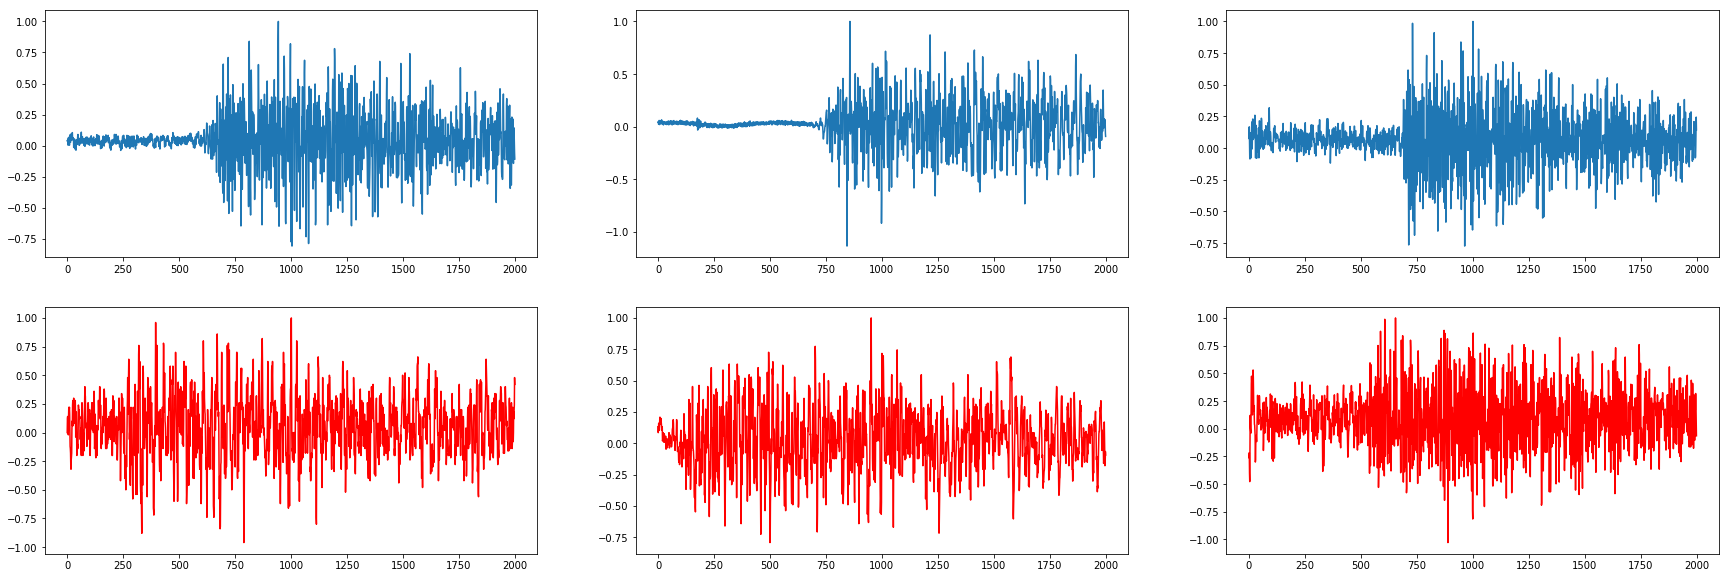

In [48]:
# Try to plot what class-1 and class0 correspond to
num_images = 3
class_minus = []
class_232 = []

data_mod = np.empty((qall_data.shape[0], qall_data.shape[1], 1))
data_mod[:, :, 0] = qall_data

for _ in range(qall_data.shape[0]):
    if len(class_minus) == num_images and len(class_232) == num_images:
        break
    
    random_image = np.random.randint(qall_data.shape[0], size = 1)
    if clustering.labels_[random_image[0]] == -1 and len(class_minus) < num_images:
        class_minus.append(random_image[0])
    elif clustering.labels_[random_image[0]] == 0 and len(class_232) < num_images:
        class_232.append(random_image[0])

# encoded_imgs = encoder.predict(data_mod)
# decoded_imgs = autoencoder.predict(data_mod)

print(x_test.shape)
# print(decoded_imgs.shape)
print(class_232)

plt.figure(figsize=(30, 10))
#scalograms are 256 by 512

for i in range(3):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.plot(data_mod[class_minus[i], :, 0])
    # plt.plot(decoded_imgs[class_minus[i], :, 0])
    
    # plot encoded image
#     ax = plt.subplot(3, num_images, num_images + i + 1)
#     plt.imshow(encoded_imgs[image_idx, :, 256].reshape(8, 5))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.axis('equal')

    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.plot(data_mod[class_232[i], :, 0],'r')
    # plt.plot(decoded_imgs[class_232[i], :, 0])

plt.show()

(5705, 2000, 1)
[2307, 7231, 12173]


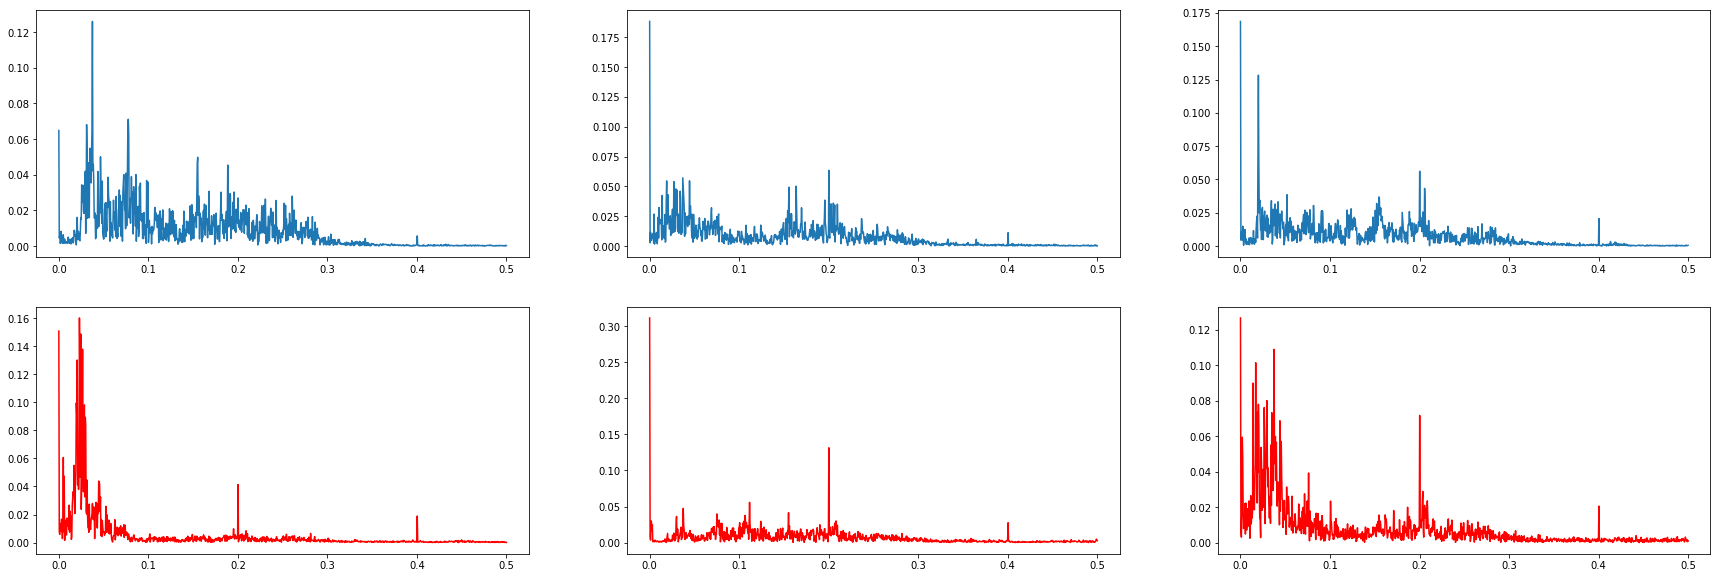

In [49]:
from scipy.fftpack import fft

N = 2000
T = 1

num_images = 3
class_minus = []
class_31 = []

for _ in range(qall_data.shape[0]):
    if len(class_minus) == num_images and len(class_31) == num_images:
        break
    
    random_image = np.random.randint(qall_data.shape[0], size = 1)
    if clustering.labels_[random_image[0]] == -1 and len(class_minus) < num_images:
        class_minus.append(random_image[0])
    elif clustering.labels_[random_image[0]] == 0 and len(class_31) < num_images:
        class_31.append(random_image[0])

# decoded_imgs = autoencoder.predict(data_mod)

print(x_test.shape)
# print(decoded_imgs.shape)
print(class_31)

plt.figure(figsize=(30, 10))
#scalograms are 256 by 512

for i in range(3):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    yf = fft(qall_data[class_minus[i]])
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    # plt.plot(decoded_imgs[class_minus[i], :, 0])
    
    # plot encoded image
#     ax = plt.subplot(3, num_images, num_images + i + 1)
#     plt.imshow(encoded_imgs[image_idx, :, 256].reshape(8, 5))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.axis('equal')

    ax = plt.subplot(2, num_images, num_images + i + 1)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    yf = fft(qall_data[class_31[i]])
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), 'r')
    # plt.plot(decoded_imgs[class_31[i], :, 0])

plt.show()

In [61]:
# Now let's try to cross comparing the results
# Class 0 is more like the top cluster
q001_t = np.load('/data0/stephey/processed_data/q001_t_cut.npy')
q003_t = np.load('/data0/stephey/processed_data/q003_t_cut.npy')
q076_t = np.load('/data0/stephey/processed_data/q076_t_cut.npy')
q103_t = np.load('/data0/stephey/processed_data/q103_t_cut.npy')

q103_class_0 = q103_data[clustering.labels_[boundary3:] == 0]

q001_time_raw = np.load('/data1/ryan/dataset/time_q001_bot.npy')
q003_time_raw = np.load('/data1/ryan/dataset/time_q003_bot.npy')
q076_time_raw = np.load('/data1/ryan/dataset/time_q076_bot.npy')
q103_time_raw = np.load('/data1/ryan/dataset/time_q103_bot.npy')

print(q001_t[:])
print(q001_time_raw[:])

print(len(q001_t))
print(len(q001_time_raw))

[3.45125300e+06 3.46012900e+06 4.41080000e+06 ... 1.85847370e+08
 1.85847999e+08 1.85860397e+08]
[  5607370   8363635   8835875 ... 185884022 185892489 185906332]
2703
6139


In [57]:
# Add some tolerance for the data comparison
q001_time = []
q001_time_copy = list(q001_t)

for x in q001_t:
    for j in range(2000):
        j -= 1000
        temp = x + j
        if temp in q001_time_copy:
            q001_time.append(q001_time_copy.index(x))
            break

prin.t(q001_time)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,